## The Coverage-Guided Fuzzer

In this notebook, we implemented a simple coverage-guided fuzzer. 

There are several different coverage criteria, including:
- **Function coverage** – Has each function (or subroutine) in the program been called?
- **Statement coverage** – Has each statement in the program been executed?
- **Edge coverage** – has every edge in the Control flow graph been executed?
- **Branch coverage** – Has each branch (also called DD-path) of each control structure (such as in if and case statements) been executed? For example, given an if statement, have both the true and false branches been executed? Notice that this one is a subset of Edge coverage.
- **Condition coverage** (or predicate coverage) – Has each Boolean sub-expression evaluated both to true and false?

In this assignment, we select 3 coverage criteria, and this notebook is about using **branch coverage** as a guide for testing.

### Branch Coverage

#### Library import

Import necessary libraries, 
**RandomFuzzer** for gengerating the random inputs, **MutationFuzzer** is used to generate the inputs from the seed, **Coverage** is used to track the covered statments.

In [231]:
from fuzzingbook.Fuzzer import RandomFuzzer
from fuzzingbook.MutationFuzzer import MutationFuzzer
from fuzzingbook.Coverage import Coverage

import random
import inspect

# we use several keywords to detect the control statements
control_keywords = ['if', 'else', 'elif', 'while', 'for']

# the trials for repetition
trials = 400

#### One program for testing the fuzzer

In [232]:
def is_valid_email(email):
    """This is an example test program for the 
    branch coverage guided fuzzy testing.
    Since it is not our focus, it may 
    contain errors in this program.
    """
    try:
        email_elems = email.split('@')
        if len(email_elems) == 2:
            email_id, email_domain = email_elems
            # check for domain name
            valid_domain = True
            for domain_char in email_domain:
                if domain_char.isalpha() or domain_char in ['@', '-', '.'] or domain_char.isdigit():
                    continue
                else:
                    valid_domain = False
            if valid_domain:
                # now check the email local-part
                if len(email_id) > 64:
                    return False
                else:
                    if ' ' in email_id:
                        if '"' not in email_id:
                            return False
                        elif email_id.index('"') < email_id.index(' '):
                            return True
                    else:
                        return True
            else:
                return False
        elif len(email_elems) == 1:
            return False
        else:
            return False
    except ValueError:
        return False

#### Getting the source code

In [221]:
# inspect the source code the program and store the soure code into source_code_lines
source_code_lines = inspect.getsource(is_valid_email).splitlines()

#### Common functions for calculating the coverage

In this part, we define three functions, **branch_coverage**, **calculate_cumulative_coverage**, and **check_control_statements** for collecting the covered line pairs, collecting the cumulative covered lines and checking whether the statements are control statements.  

In [226]:
def branch_coverage(trace):
    """This function takes the covered trace, 
    and return the covered line pairs.
    @trace: the covered trace.
    """
    coverage = set()
    past_line = None
    for line in trace:
        if past_line is not None:
            coverage.add((past_line, line))
        past_line = line

    return coverage

In [228]:
def calculate_cumulative_coverage(input_population, function):
    """This function is used for collecting the coverged lines pairs.
    It takes two params,
    @input_population: a list of inputs 
    @function: the target function for testing
    and rerurn the cumulated covered line pairs.
    """
    cumulative_coverage = []
    for inp in input_population:
        with Coverage() as cov:
            try:
                function(inp)
            except:
                # we ignore exceptions for the purpose of this code,
                # but some exceptions may be interesting
                pass
        cumulative_coverage.append(branch_coverage(cov.trace()))
    return cumulative_coverage

In [229]:
def check_control_statements(covered_pair_lines, source_code_lines):
    """This function checks whether the lines are control statements or not.
    @covered_pair_lines: the covered line pairs
    @source_code_lines: the source code lines
    and return the list of covered lines.
    """
    covered_control_list = set()
    for covered_pair_line in covered_pair_lines:
        source_code_line = source_code_lines[covered_pair_line[0][-1]]
        if any([x in source_code_line for x in control_keywords]):
            covered_control_list.add(covered_pair_line)
    return covered_control_list

#### Random Fuzzer

In [237]:
branch_coverage_set = set()
covered_branch_count_list_random = [] # keep the cumulative covered branch count

random_fuzzer = RandomFuzzer() # random fuzzer

inputs_random = [random_fuzzer.fuzz() for _ in range(trials)] # random inputs

# get the covered line numbers
coverages_line_numbers = calculate_cumulative_coverage(
    inputs_random, is_valid_email)

# check whether the covered line are control statements or not
# and keep the coverage count in a list for later ploting
for coverages_line_number in coverages_line_numbers:
    new_covered_statements = check_control_statements(
        coverages_line_number, source_code_lines)
    branch_coverage_set |= new_covered_statements
    covered_branch_count_list_random.append(len(branch_coverage_set))

#### Branch coverage fuzzer

In [241]:
def weighted_random_seed(seed_list):
    """Weighted random sampling, 
    based on the coverage improvements"""
    _weights = [x[1] for x in seed_list]
    return random.choices(population=seed_list, weights=_weights, k=1)[0]

In [247]:
seed_initial = 'sd@sd.com'  # initial seed
seed_generated = []  # generated seeds based on the coverage improvements
covered_branch_count_list_coverage = []  # keep the coverage count
covered_branches_set_coverage = set()  # keep the coverage information


for _ in range(trials):
    if not seed_generated:
        _seed = seed_initial
    else:
        _seed = weighted_random_seed(seed_generated)[0]

    # based on the seed, generate the inputs
    mutation_fuzzer = MutationFuzzer(seed=[_seed])
    inputs_mutation = random.choice(
        [mutation_fuzzer.fuzz() for i in range(10)][1:])

    # get the coverage information
    coverages_line_number = calculate_cumulative_coverage(
        [inputs_mutation], is_valid_email)[0]
    covered_statements = check_control_statements(
        coverages_line_number, source_code_lines)

    # if the generated seed is empty
    if not seed_generated:
        seed_generated.append((inputs_mutation, 0))
        covered_branches_set_coverage |= covered_statements
        covered_branch_count_list_coverage.append(
            len(covered_branches_set_coverage))
    # the generated seed's coverage information is improved
    elif not covered_statements.issubset(covered_branches_set_coverage):
        covered_branches_set_coverage |= covered_statements
        covered_branch_count_list_coverage.append(
            len(covered_branches_set_coverage))
        increased_coverage = covered_branch_count_list_coverage[-1] - \
            covered_branch_count_list_coverage[-2]
        seed_generated.append((inputs_mutation, increased_coverage))
    else:  # not improved
        covered_branch_count_list_coverage.append(
            len(covered_branches_set_coverage))

#### Visulazing the results

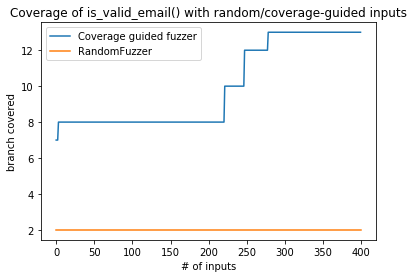

In [250]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(covered_branch_count_list_coverage)
plt.plot(covered_branch_count_list_random)
plt.title('Coverage of is_valid_email() with random/coverage-guided inputs')
plt.xlabel('# of inputs')
plt.ylabel('branch covered')
plt.legend(['Coverage guided fuzzer', 'RandomFuzzer'], loc='upper left')